# Introduction

This notebook will be used to analyze both the Boston and Seattle Airbnb datasets from Kaggle

# Business Questions

Q1: Analyzing the temporal data for both cities, do we see growth rate trends which could be investigated in other cities?

Q2: What are the common rental features which drive good review scores?

Q3: What are the common host features which drive high occupancy rates?


In [102]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import skew
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi
import random
from transformers import pipeline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")

# Data Loading

In [4]:
df_se_calendar = pd.read_csv("./data/small_data_100MB/seattle/archive/calendar.csv")
df_se_listings = pd.read_csv("./data/small_data_100MB/seattle/archive/listings.csv")
df_se_reviews = pd.read_csv("./data/small_data_100MB/seattle/archive/reviews.csv")


df_bo_calendar = pd.read_csv("./data/small_data_100MB/boston/archive/calendar.csv")
df_bo_listings = pd.read_csv("./data/small_data_100MB/boston/archive/listings.csv")
df_bo_reviews = pd.read_csv("./data/small_data_100MB/boston/archive/reviews.csv")


In [5]:
for data in [df_se_calendar,df_se_listings,df_se_reviews]:
    display(data.head())
    print(data.shape)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


(1393570, 4)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,...,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,...,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,...,t,1,6,17,220,2016-01-04,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,...,t,0,0,0,143,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,https://a1.muscache.com/a

(3818, 92)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


(84849, 6)


In [6]:
for data in [df_bo_calendar,df_bo_listings,df_bo_reviews]:
    display(data.head())
    print(data.shape)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


(1308890, 4)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,...,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,...,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,https://www.airbnb.com/users/show/16701,Phil,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",...,NaN,19,46,61,319,2016-09-06,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston a

(3585, 95)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


(68275, 6)


# Data Wrangling

## Common Functions

In [83]:
def transform_column_to_datetime(df, column_name):
    """
    Transform a specified column in a DataFrame to datetime using pd.to_datetime.

    Args:
        df (pd.DataFrame): The DataFrame.
        column_name (str): The name of the column to transform.

    Returns:
        pd.DataFrame: The DataFrame with the specified column transformed to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name])
    return df

In [84]:
def format_money_columns(df, money_columns):
    """
    Reformat money-related columns in a DataFrame by removing symbols like "$" and ","
    and converting them to float type.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be reformatted.
        money_columns (list): A list of column names containing money-related features.

    Returns:
        pd.DataFrame: The DataFrame with reformatted money columns.
    """
    for column in money_columns:
        df[column] = df[column].str.replace(r"\$|,", "", regex=True).astype("float32")

    return df

In [99]:
def convert_to_bool(df, bool_feature_mapping):
    """
    Convert specified columns in a DataFrame to boolean values based on the provided mapping and return a new DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        bool_feature_mapping (dict): A dictionary mapping column names to value mappings.

    Returns:
        pandas.DataFrame: A new DataFrame with specified columns converted to boolean values.
    """
    # Create a new DataFrame by copying the original
    new_df = df.copy()

    # Convert the specified columns to boolean values
    for column, mapping in bool_feature_mapping.items():
        new_df[column] = new_df[column].map(mapping).astype(bool)

    return new_df


## Calendar

In [32]:
def calendar_convert_date_and_price(df):
    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Ensure 'price' column is of string type
    df['price'] = df['price'].astype(str)

    # Convert the 'price' column to numeric, handling NaN values as 0
    df['price'] = pd.to_numeric(df['price'].str.replace('[\$,]', '', regex=True), errors='coerce').fillna(0)

    return df

In [33]:
def calendar_plot_prices_over_years(df, listing_ids):
    # Filter the DataFrame for the specified listing_ids
    df_filtered = df[df['listing_id'].isin(listing_ids)]
    
    # Create a pivot table to group data by year and listing_id
    pivot_table = df_filtered.pivot_table(index=df_filtered['date'].dt.year, columns='listing_id', values='price', aggfunc='mean')

    # Plot the data
    pivot_table.plot(kind='line', figsize=(12, 6), legend=True)
    plt.title('Price Over Years for Selected Listing IDs')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show()

In [96]:
# Sample the dataframe before preprocessing
display(df_se_calendar.head())

# Get the non-null counts and data types
print(df_se_calendar.info())

# Display the summary of unique value distribution
print(df_se_calendar.nunique())

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,0.0
3,241032,2016-01-07,f,0.0
4,241032,2016-01-08,f,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       1393570 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB
None
listing_id    3818
date           365
available        2
price          670
dtype: int64


In [101]:
mapping = {
    'available': {'t': 1, 'f': 0}
}
df1 = convert_to_bool(df_se_calendar, mapping)
# Sample the dataframe before preprocessing
display(df1.head())

# Get the non-null counts and data types
print(df1.info())

# Display the summary of unique value distribution
print(df1.nunique())

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,0.0
3,241032,2016-01-07,False,0.0
4,241032,2016-01-08,False,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  bool          
 3   price       1393570 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 33.2 MB
None
listing_id    3818
date           365
available        2
price          670
dtype: int64


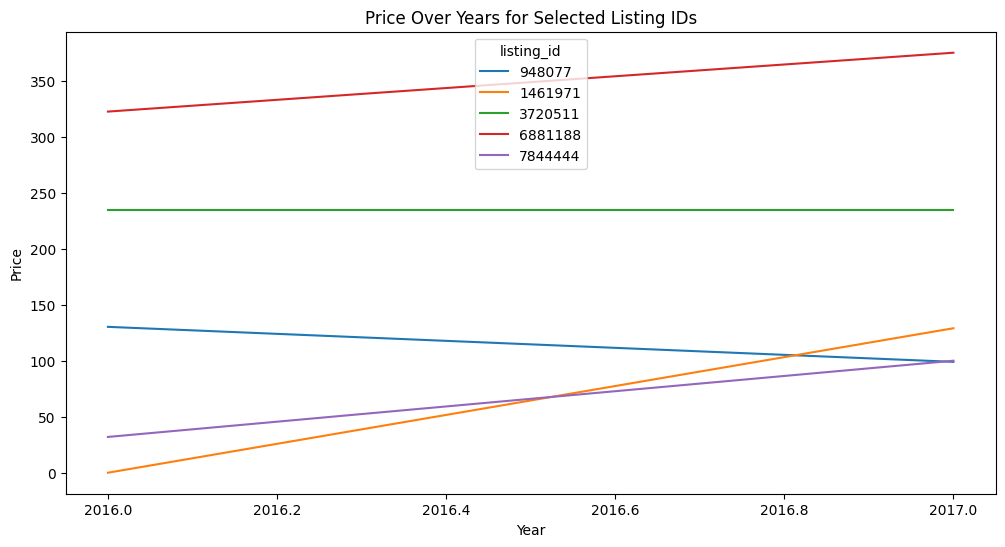

In [27]:
# Seattle Examination
df1 = listings_convert_date_and_price(df_se_calendar)
# Randomly select 5 listing_ids from your dataset
random.seed(42)  # Set a seed for reproducibility
selected_listing_ids = random.sample(df1['listing_id'].unique().tolist(), 5)

# Call the function with the selected listing_ids
listings_plot_prices_over_years(df1, selected_listing_ids)

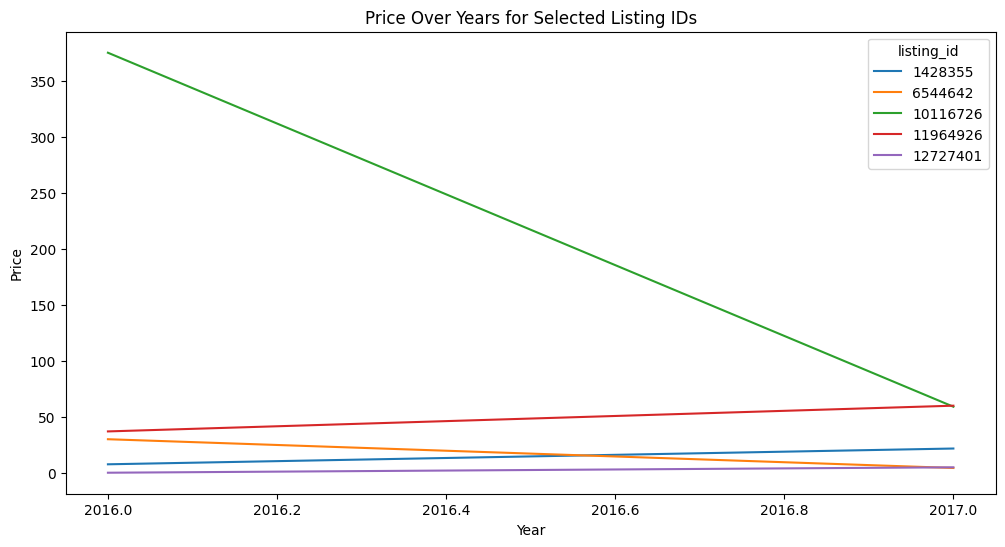

In [31]:
# Seattle Examination
df1 = listings_convert_date_and_price(df_bo_calendar)
# Randomly select 5 listing_ids from your dataset
random.seed(43)  # Set a seed for reproducibility
selected_listing_ids = random.sample(df1['listing_id'].unique().tolist(), 5)

# Call the function with the selected listing_ids
listings_plot_prices_over_years(df1, selected_listing_ids)

## Listings

In [44]:
def listings_wrangle_dataframe(df):
    """
    Perform data wrangling on a DataFrame by dropping duplicate columns, columns with full NA,
    columns with only one unique value, and columns representing URLs.

    Args:
        df (pd.DataFrame): The DataFrame to be wrangled.

    Returns:
        pd.DataFrame: The wrangled DataFrame.
    """
    # Drop duplicate columns
    df = df.T.drop_duplicates().T

    # Drop columns with full NA
    df.dropna(axis=1, how="all", inplace=True)

    # Drop columns with only one unique value
    df.drop([c for c in df.columns if df[c].nunique() == 1], axis=1, inplace=True)

    # Drop columns representing URL
    df.drop(df.columns[df.columns.str.contains("url")], axis=1, inplace=True)

    return df

In [121]:
def columns_with_low_non_null_counts(df, threshold):
    # Get the non-null counts
    non_null_counts = df.count()
    
    # Filter column names with non-null counts less than the threshold
    low_count_columns = non_null_counts[non_null_counts < threshold]
    
    # Return a list of column names
    return low_count_columns.index.tolist()

In [124]:
lst = columns_with_low_non_null_counts(df_se_listings, 2863)
lst

['neighborhood_overview',
 'notes',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'license']

In [125]:
lst = columns_with_low_non_null_counts(df_bo_listings, 2688)
lst

['space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'has_availability',
 'license',
 'jurisdiction_names']

In [120]:
df = get_sorted_column_info(df_se_listings)
#print("Seattle")
df

,Non-Null Counts,Data Types
id,3818,int64
neighbourhood_cleansed,3818,object
guests_included,3818,int64
price,3818,object
amenities,3818,object
bed_type,3818,object
accommodates,3818,int64
room_type,3818,object
is_location_exact,3818,object
listing_url,3818,object


In [105]:
# Get the non-null counts and data types
non_null_counts = df_se_listings.count()
data_types = df_se_listings.dtypes

# Create a DataFrame to store the non-null counts and data types
column_info = pd.DataFrame({'Non-Null Counts': non_null_counts, 'Data Types': data_types})

# Sort the DataFrame by the number of non-null values
sorted_column_info = column_info.sort_values(by='Non-Null Counts', ascending=False)

# Print the sorted columns with their non-null counts and data types
print(sorted_column_info)

                                  Non-Null Counts Data Types
id                                           3818      int64
neighbourhood_cleansed                       3818     object
guests_included                              3818      int64
price                                        3818     object
amenities                                    3818     object
bed_type                                     3818     object
accommodates                                 3818      int64
room_type                                    3818     object
is_location_exact                            3818     object
listing_url                                  3818     object
latitude                                     3818    float64
country                                      3818     object
country_code                                 3818     object
smart_location                               3818     object
market                                       3818     object
state                   

In [107]:
# Get the non-null counts, data types, and unique values
non_null_counts = df_se_listings.count()
data_types = df_se_listings.dtypes
unique_values = df_se_listings.nunique()

# Create a DataFrame to store the non-null counts, data types, and unique values
column_info = pd.DataFrame({'Non-Null Counts': non_null_counts, 'Data Types': data_types, 'Unique Values': unique_values})

# Sort the DataFrame by the number of non-null values
sorted_column_info = column_info.sort_values(by='Non-Null Counts', ascending=False)

# Print the sorted columns with their non-null counts, data types, and unique values
print("Seattle Listings")
print(sorted_column_info)

Seattle Listings
                                  Non-Null Counts Data Types  Unique Values
id                                           3818      int64           3818
neighbourhood_cleansed                       3818     object             87
guests_included                              3818      int64             15
price                                        3818     object            273
amenities                                    3818     object           3284
bed_type                                     3818     object              5
accommodates                                 3818      int64             15
room_type                                    3818     object              3
is_location_exact                            3818     object              2
listing_url                                  3818     object           3818
latitude                                     3818    float64           3818
country                                      3818     object           

Since we want to do analysis comparing both the Boston and Seattle datasets while ensuring that a good protion of review score columns are included in the analysis, it was determined that the Boston dataset provide the non-null counts precentage limit at 75%.

Consequently, for Boston, the following columns are removed (e.g., Non-null counts <2688 for 3585 elements) :
| Column                         | Non-Null Counts | Data Type | Unique |
|--------------------------------|-----------------|-----------|--------|
| space                          | 2528            | object    | 2268   |
| cleaning_fee                   | 2478            | object    | 79     |
| house_rules                    | 2393            | object    | 1928   |
| transit                        | 2295            | object    | 1859   |
| host_about                     | 2276            | object    | 1240   |
| neighborhood_overview          | 2170            | object    | 1728   |
| access                         | 2096            | object    | 1762   |
| interaction                    | 2031            | object    | 1617   |
| notes                          | 1610            | object    | 1269   |
| security_deposit               | 1342            | object    | 54     |
| weekly_price                   | 892             | object    | 243    |
| monthly_price                  | 888             | object    | 288    |
| square_feet                    | 56              | float64   | 37     |
| has_availability               | 0               | float64   | 0      |
| license                        | 0               | float64   | 0      |
| jurisdiction_names             | 0               | float64   | 0      |
| neighbourgroup_cleansed        | 0               | float64   | 0      |


For Seattle, the following columns are removed (e.g., Non-null counts < 2863 for 3818 elements):

| Column Name               | Non-null Counts | Data Type | Unique    |
|---------------------------|-----------------|-----------|-----------|
| cleaning_fee              | 2788            | object    | 118       |
| neighborhood_overview     | 2786            | object    | 2506      |
| notes                     | 2212            | object    | 1999      |
| weekly_price              | 2009            | object    | 395       |
| security_deposit          | 1866            | object    | 46        |
| monthly_price             | 1517            | object    | 356       |
| square_feet               | 97              | float64   | 47        |
| license                   | 0               | float64   | 0         |


Upon examination, the Boston AirBnB has the superset of features which should be dropped for comparative analysis. 

In [ ]:
# Drop non-null counts less than a specific threshold

In [ ]:
# Drop URLs

In [ ]:
# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Drop the columns below a specific threshold in list

In [ ]:
lst = columns_with_low_non_null_counts(df_bo_listings, 2688)
lst

In [132]:
lst

['space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'has_availability',
 'license',
 'jurisdiction_names']

In [153]:
df_listings = df_bo_listings.copy()

In [154]:
df_bo_listings.shape

(3585, 95)

In [155]:
df_listings.shape

(3585, 95)

In [156]:
# Drop columns with low non-null counts based on sorted_column_info
df_listings.drop(columns=lst, inplace=True)
df_listings.shape

(3585, 78)

In [157]:
# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T
df_listings.shape

(3585, 77)

In [158]:
# Drop columns with full NA
df_listings.dropna(axis=1, how="all", inplace=True)
df_listings.shape

(3585, 77)

In [159]:
# Drop columns representing URL
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")], axis=1, inplace=True)
df_listings.shape

(3585, 69)

In [ ]:
# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1, how="all", inplace=True)

# Drop columns representing URL
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")], axis=1, inplace=True)

# Drop columns with low non-null counts based on sorted_column_info
df_listing.drop(columns=lst, inplace=True)

In [109]:
# Get the non-null counts, data types, and unique values
non_null_counts = df_bo_listings.count()
data_types = df_bo_listings.dtypes
unique_values = df_bo_listings.nunique()

# Create a DataFrame to store the non-null counts, data types, and unique values
column_info = pd.DataFrame({'Non-Null Counts': non_null_counts, 'Data Types': data_types, 'Unique Values': unique_values})

# Sort the DataFrame by the number of non-null values
sorted_column_info = column_info.sort_values(by='Non-Null Counts', ascending=False)

# Print the sorted columns with their non-null counts, data types, and unique values
print("Boston Listings")
print(sorted_column_info)

Boston Listings
                                  Non-Null Counts Data Types  Unique Values
id                                           3585      int64           3585
longitude                                    3585    float64           3585
price                                        3585     object            324
amenities                                    3585     object           3092
bed_type                                     3585     object              5
accommodates                                 3585      int64             14
room_type                                    3585     object              3
is_location_exact                            3585     object              2
latitude                                     3585    float64           3585
host_has_profile_pic                         3585     object              2
listing_url                                  3585     object           3585
country_code                                 3585     object            

In [103]:
# Sample the dataframe before preprocessing
display(df_se_listings.head())

# Get the non-null counts and data types
print(df_se_listings.info())

# Display the summary of unique value distribution
print(df_se_listings.nunique())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [48]:
df = listings_wrangle_dataframe(df_bo_listings)
print(f"df_bo_listings.shape : {df_bo_listings.shape}")
print(f"df.shape : {df.shape}")

df_bo_listings.shape : (3585, 95)
df.shape : (3585, 74)


In [ ]:
# List of money-related columns
money_columns = ['price', 'weekly_price', 'monthly_price',
                'security_deposit', 'cleaning_fee', 'extra_people']

# Call the format_money_columns function to reformat the money columns
df = format_money_columns(df, money_columns)

# The DataFrame now contains the reformatted money columns
print(df)

## Reviews

In [77]:
import torch
from transformers import pipeline


In [51]:
# Seattle
df = transform_column_to_datetime(df_se_reviews, 'date')